# Financial Analyst Agent for Annual Report Writing

In [16]:
import os
import autogen
from autogen.cache import Cache

from finrobot.utils import register_keys_from_json
from finrobot.toolkits import register_toolkits
from finrobot.functional import (
    ReportChartUtils,
    ReportAnalysisUtils,
    IPythonUtils,
    ReportLabUtils,
    TextUtils,
)
from finrobot.data_source import FMPUtils,YFinanceUtils
from textwrap import dedent

## Data

### 1. `FMPUtils`

封装了与 Financial Modeling Prep (FMP) API 交互的各种功能，用于获取股票的财务数据。

**`get_sec_report`由Agent直接调用**，(但是获取到url后，Agent好像没有继续对这份数据分析); **`get_financial_metrics` 嵌套在 `get_competitors_analysis(...)`工具中调用**

- `get_target_price`: 获取给定股票在指定日期的目标价格

- <mark>`get_sec_report`: 获取给定股票和年份的 10-K (年报) 报告的 URL 和归档日期</mark>
- `get_historical_market_cap`: 获取给定股票在指定日期的历史市值
- `get_historical_bvps`: 获取给定股票在指定日期的历史每股账面价值
- **`get_financial_metrics`: 获取给定股票过去几年（由`years`参数指定，默认为4年）的多种财务指标，并以 `DataFrame` 的形式返回**
- `get_competitor_financial_metrics`: 获取指定公司及其竞争对手公司过去几年的财务指标

**`FMPUtils.get_sec_report`**

Agent 直接调用

In [17]:
# FMPUtils.get_sec_report("GOOGL")

In [18]:
# 获取到的原始数据

# import os
# import requests

# fmp_api_key = os.environ["FMP_API_KEY"]
# ticker_symbol = "GOOGL"

# url = f"https://financialmodelingprep.com/api/v3/sec_filings/{ticker_symbol}?type=10-k&page=0&apikey={fmp_api_key}"

# response = requests.get(url)
# response.json()

# 如果用户输入的年份是 "latest"，则直接取列表中第一个 filing（默认最靠前的就是最近的一份），从中提取
# 如果指定了具体年份：遍历所有 filing；找到第一个 fillingDate 开头是该年份的；获取它的链接和日期后 break 退出。

### 2. `YFinanceUtils`

通过股票代码（ticker symbol）从雅虎财经（Yahoo Finance）获取各种类型的股票和公司财务数据. <mark>由`ReportAnalysisUtils`下的函数调用，返回数据和 instruction 拼接成 prompt 给到Agent。</mark>

- `get_stock_data(...)`: 获取指定股票在特定日期范围内的历史股价数据。

- `get_stock_info(...)`: 获取股票的最新信息，如市值、市盈率等。
- `get_company_info(...)`: 获取公司的基本信息（公司名称、行业、板块、国家、网站）
- `get_stock_dividends(...)`: 获取股票的历史股息数据.
- `get_income_stmt(...)`: 获取公司的最新损益表 
- `get_balance_sheet(...)`: 获取公司的最新资产负债表
- `get_cash_flow(...)`: 获取公司的最新现金流量表
- `get_analyst_recommendations(...)`: 获取最新的分析师评级建议，并返回最常见的建议及其数量


### 3. `SECUtils`

通过股票代码 (ticker) 从 SEC EDGAR 系统中查找、下载和提取 10-K 年度报告的特定部分. <mark>由`ReportAnalysisUtils`下的函数调用，返回数据和 instruction 拼接成 prompt 给到Agent。</mark>

- `get_10k_metadata(...)`: 在指定的时间范围内搜索特定公司的 10-K 文件，并返回最新一份文件的元数据
  
- `download_10k_filing(...)`: 下载指定公司在特定时间范围内的最新 10-K 文件的 HTML 版本
- `download_10k_pdf(...)`: 下载指定公司在特定时间范围内的最新 10-K 文件的 PDF 版本
- `get_10k_section(...)`: 从指定的 10-K 报告中提取特定章节的文本内容。支持缓存机制

## Function

### 1. `ReportAnalysisUtils`

<mark>数据 + 指令 封装为prompt，给LLM执行</mark>

- 使用 `YFinanceUtils`, `SECUtils`, `FMPUtils` 来获取相关的财务数据或报告文本。

- 定义一个详细的 `instruction` 字符串，指导如何进行分析。

包含的function：

|function| desc | data | output|
|---|---|---| --- | 
|`analyze_income_stmt(...)` | 获取指定公司的利润表及其 10-K 报告中的相关部分，并生成分析利润表的指令| - 通过 `YFinanceUtils.get_income_stmt()` 获取利润表数据 <br> - 通过 `SECUtils.get_10k_section()` 获取 10-K 报告的第 7 部分| [income_stmt_analysis_META.txt](/Users/mig217/FinRobot/finrobot/report/income_stmt_analysis_META.txt) | 
|`analyze_balance_sheet(...)`| 获取资产负债表及其 10-K 报告相关部分，并生成分析资产负债表的指令| |
|`analyze_cash_flow(...)`|获取现金流量表及其 10-K 报告相关部分，并生成分析现金流量表的指令| | 
| `analyze_segment_stmt(...)`| 获取利润表和 10-K 报告相关部分，并生成创建分部业务分析的指令| | 
| `income_summarization(...)`| 基于已有的利润表分析和分部业务分析，生成一个综合总结的指令| 除了常规参数，还接收 `income_stmt_analysis` 和 `segment_analysis` 作为输入| [income_summarization.txt](/Users/mig217/FinRobot/report/income_summarization.txt) |
| `get_risk_assessment(...)`| 获取公司的风险因素（通常来自 10-K 报告的 "Risk Factors" 部分），并生成总结公司前三大关键风险的指令| | [apple_risk_assessment.txt](/Users/mig217/FinRobot/report/apple_risk_assessment.txt) |
| `get_competitors_analysis(...)`| 分析一家公司与其竞争对手之间的财务指标差异，并准备分析提示 | 使用 `FMPUtils.get_competitor_financial_metrics()` 获取公司及其竞争对手过去4年的财务指标| 
| `analyze_business_highlights(...)`| 获取公司的业务摘要和 10-K 报告相关部分，并生成描述公司各业务线业绩亮点的指令| |
| `analyze_company_description(...)`| 获取公司描述和 10-K 报告相关部分，并生成描述公司行业、优势、趋势和战略举措的指令| |
| `get_key_data(...)`| 返回给定股票代码和财报申报日的关键财务数据。这个方法与其他方法不同，它直接返回一个包含数据的字典，而不是生成一个用于分析的 prompt 字符串。|- 使用 `YFinanceUtils.get_stock_data()` 获取申报日前一年的历史股价数据 <br> - 使用 `YFinanceUtils.get_stock_info()` 获取股票基本信息 <br> - 计算收盘价、过去6个月的平均日交易量、52周最高/最低价 <br> - 使用 `YFinanceUtils.get_analyst_recommendations()` 获取分析师评级 <br> - 使用 `FMPUtils.get_target_price()` 获取目标价 <br> - 使用 `FMPUtils.get_historical_market_cap()` 获取历史市值 <br> - 使用 `FMPUtils.get_historical_bvps()` 获取历史每股账面价值 | 

In [19]:
# from finrobot.data_source import SECUtils
# print(SECUtils.get_10k_section("GOOGL", "2024", 7))

### 2. `ReportChartUtils`

用于生成更复杂的报告用图表，比如公司股价与标普500指数的对比图，以及市盈率(PE)和每股收益(EPS)的趋势图

|function | arguments | |
|---|---|---|
|`get_share_performance` | - `ticker_symbol`: 股票代码。<br> - `filing_date`: 报告的申报日期，以此日期为基准向前追溯一年。<br> - `save_path`: 图表保存路径。| - 获取目标股票和标普500指数在过去一年的收盘价。<br> - 获取目标股票的公司信息 <br> - 计算目标股票和标普500指数在这一年内的累积收益率。<br> - 使用 matplotlib 绘制这两条收益率曲线在同一个图表上|
| `get_pe_eps_performance` | - `ticker_symbol`: 股票代码。<br> - `filing_date`: 报告的申报日期。<br> - years: (可选) 从申报日期回溯的年数，用于分析历史PE和EPS，默认为4年。 <br> - save_path: (可选) 图表保存路径。| - 获取公司的历史利润表数据，并从中提取每股收益 (EPS)。<br> - 获取公司过去 years + 1 年的每日历史股价数据。多获取一年是为了确保有足够的历史股价数据来匹配较早的EPS财报日期|


charting.py 文件下还有 `MplFinanceUtils` 类, 这个类主要封装了使用 `mplfinance` 库绘制股票价格图表的功能

In [20]:
# from PIL import Image

# img = Image.open("../finrobot/report/PE_EPS_GOOG.png")
# display(img)

### 3. `ReportLabUtils`

使用 `reportlab` 库动态生成一份包含文本、表格和图片的PDF格式股票研究报告。

**数据来源:**

- 文本内容 (如业务概览、风险评估等) 作为方法参数直接传入。

- 图片 (股价图、PE/EPS图) 的路径作为参数传入，意味着这些图片是预先生成好的。

- 财务数据通过 `FMPUtils` 和 `YFinanceUtils` (推测是自定义的工具类) 获取。

- 关键数据通过 `ReportAnalysisUtils` 获取。

**结构化报告:** 

- 第一页 (两栏):
  - 左栏：报告标题、业务概览、市场地位、经营成果、财务指标表格。
  - 右栏：FinRobot信息、关键数据表格、股价表现图、PE/EPS图。

- 第二页及之后 (单栏):
  - 风险评估、竞争对手分析。

## Agent

### CoT

**Financial CoT（金融链式思维）流程：**

1. **收集初步数据**：包括10-K报告、市场数据和财务比率

2. **分析财务报表**：包括资产负债表、利润表和现金流量表
3. **公司概况与表现**：撰写公司介绍、业务亮点和细分业务分析
4. **风险评估**：识别并评估公司面临的主要风险
5. **财务表现可视化**：绘制市盈率（PE）和每股收益（EPS）图表
6. **整合分析内容为段落**：将上述所有内容整理为一篇连贯的总结
7. **生成 PDF 报告**：通过工具自动生成格式化好的 PDF 报告
8. **质量检查**：检查字数等内容质量要求是否达标

### WorkFlow

[Case: Google Annual Report (qwen-turbo)](https://www.notion.so/Google-Annual-Report-qwen-turbo-2067a143a768806a936df0b3b1901ade?source=copy_link)

**expert：主 Agent**
- 是整个系统对话的核心执行者，负责总体流程控制。
- 它接收指令、管理资源、调用函数和触发 expert_shadow 的工作。

**expert_shadow：内部 Agent**
- 相当于expert的“内心声音”或“写作助手”。
- 它不会独立行动，只会在被expert触发的特定条件下出现。
- 它的职责很单一：接收写作指令并完成相应内容，再返回给expert。
- 这个嵌套对话是“静默”的，不会影响主界面输出。（`register_nested_chats` 函数中设置）

**工作流程总结：**

1. expert接收到提示：“instruction & resources saved to …” → order_trigger 返回 True。`def order_trigger(sender)`
2. expert读取指令路径 → 用 order_message 构造任务内容。`def order_message`
3. 触发一个嵌套对话`register_nested_chats`
4. shadow完成任务，写好内容（如10-K分析）并返回。
5. expert获取影子的结果，用于下一步动作。

![](https://lucid.app/publicSegments/view/e95869e2-d7d8-4c2e-8dfc-2b5c19157634/image.png)

#### Prompt

In [21]:
# print(expert.system_message)

In [22]:
# print(expert_shadow.system_message)

#### Report

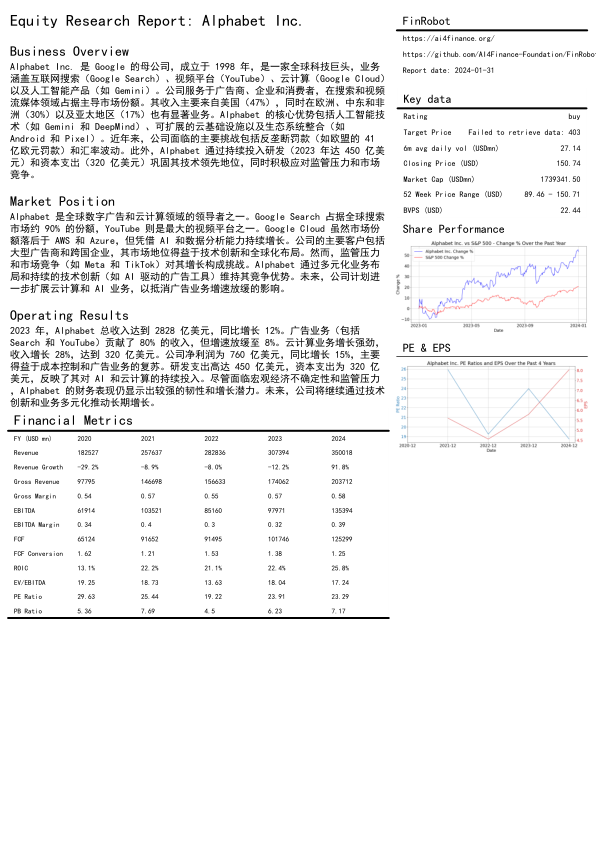

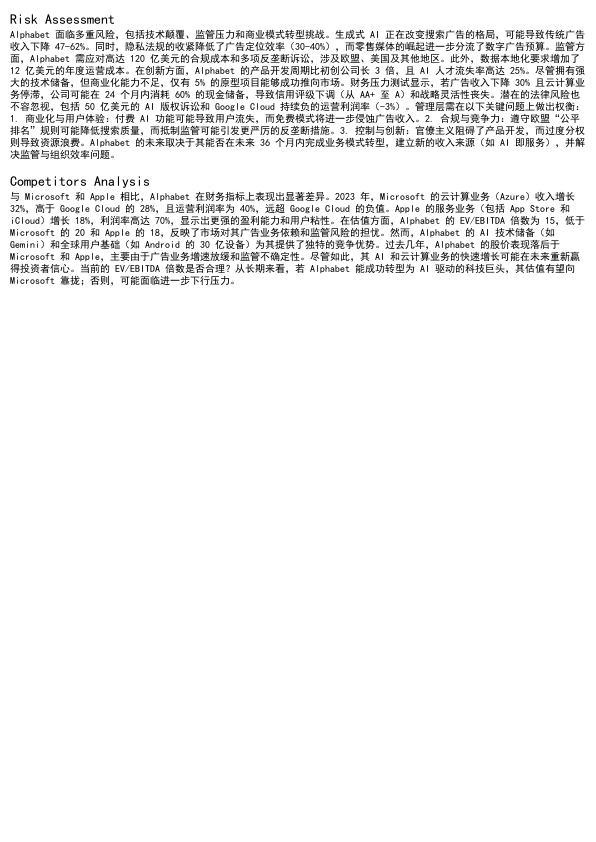

In [32]:
import io
import fitz
from PIL import Image


pdf = fitz.open("/Users/mig217/FinRobot/finrobot/report/Google_2024_Annual_Report.pdf")

for i in range(2):
    page = pdf.load_page(i)
    pix = page.get_pixmap()
    img = Image.open(io.BytesIO(pix.tobytes("png")))
    display(img)

## Demo


In this demo, we introduce an agent that can analyze financial report.

After importing all the necessary packages and functions, we also need the config for OpenAI & SecApi & FMPApi here.
- for openai configuration, rename OAI_CONFIG_LIST_sample to OAI_CONFIG_LIST and replace the api keys
- for Sec_api & FMP_api configuration, rename config_api_keys_sample to config_api_keys and replace the api keys

In [24]:
config_list = autogen.config_list_from_json(
    "../OAI_CONFIG_LIST",
    # filter_dict={
    #     "model": ["gpt-4-0125-preview"],
    # },
)
llm_config = {
    "config_list": config_list,
    "timeout": 120,
    # "temperature": 0 # for debug convenience
    "temperature": 0.5,
}
register_keys_from_json("../config_api_keys")

# Intermediate results will be saved in this directory
work_dir = "../FinRobot/report"
os.makedirs(work_dir, exist_ok=True)

For this task, we need:
- A user proxy to execute python functions and control the conversations.
- An expert agent who is proficient in financial analytical writing.
- A shadow/inner-assistant to handle isolated long-context Q&As. (Because we dont want to keep the sec files in the chat history.)
In the following cell, we define the agents, and equip them with necessary tools.

In [25]:
system_message = dedent(
    f"""
    角色：资深投资分析师
    部门：金融部
    主要职责：撰写定制化的财务分析报告

    角色描述：
    作为金融领域的资深投资分析师，你的专业能力将被用于编写契合客户特定需求的财务分析报告。该角色需要深入研究财务报表和市场数据，从中挖掘出有关公司财务表现与稳定性的洞察。你将与客户直接交流，收集核心信息，并根据反馈不断优化报告，以确保最终成果准确贴合客户预期。

    核心目标：

    分析精度：凭借严谨的分析能力解读财务数据，识别潜在趋势与异常。
    高效沟通：将复杂的财务内容转化为清晰易懂、可执行的语言，便于非专业受众理解。
    客户导向：根据客户反馈灵活调整分析内容，使报告更好地服务其战略目标。
    卓越标准：在报告编写过程中始终坚持质量与诚信，遵循严密的分析标准。

    绩效衡量指标：
    财务分析报告的有效性体现在其是否能够提供清晰、可执行的洞察，包括：辅助企业做出决策、指出运营优化方向、全面评估财务健康状况。最终的成功标准是报告是否对投资判断和战略规划产生积极作用。

    当任务完成并确认无误时，请回复 TERMINATE。
    """
)
expert = autogen.AssistantAgent(
    name="Expert_Investor",
    system_message=system_message,
    llm_config=llm_config,
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
)
expert_shadow = autogen.AssistantAgent(
    name="Expert_Investor_Shadow",
    system_message=system_message,
    llm_config=llm_config,
)
user_proxy = autogen.UserProxyAgent( 
    # 可以接收、处理信息，并根据配置做出自动回复。它既可以模拟用户行为，也可以自动执行逻辑任务
    name="User_Proxy",
    is_termination_msg=lambda x: x.get("content", "")
    and x.get("content", "").endswith("TERMINATE"),
    # human_input_mode="ALWAYS",
    human_input_mode="NEVER",
    # max_consecutive_auto_reply=10,
    code_execution_config={
        "last_n_messages": 1, # 指定自动代理在执行代码前，会参考上下文中最近的 1 条消息 来决定执行逻辑
        "work_dir": work_dir,
        "use_docker": False,
    },
)

In [26]:
register_toolkits(
    [
        FMPUtils.get_sec_report,  # Retrieve SEC report url and filing date
        IPythonUtils.display_image,  # Display image in IPython
        TextUtils.check_text_length,  # Check text length
        ReportLabUtils.build_annual_report,  # Build annual report in designed pdf format
        ReportAnalysisUtils,  # Expert Knowledge for Report Analysis
        ReportChartUtils,  # Expert Knowledge for Report Chart Plotting
    ],
    expert,
    user_proxy,
)

In this section, we introduce the **nested chat between the expert and the shadow**, which is triggered only when the expert gets response from function execution showing that an writing instruction and related context & resources are ready. The writing would then happen in this separate chat, the shadow (or call it the inner mind of expert) would do the financial writing based on the instruction and turn back to the expert. However, this chat is muted due to long context.


In [27]:
def order_trigger(sender):
    # 只有当消息包含“instruction & resources saved to”时才触发
    last_msg = sender.last_message()["content"]
    if "instruction & resources saved to" not in last_msg:
        return False

    # 提取所有路径
    cleaned = last_msg.replace("instruction & resources saved to", "").strip()
    paths = [line.strip() for line in cleaned.splitlines() if line.strip()]
    
    if not paths:
        print("[Trigger] 没有检测到任何文件路径")
        return False

    # 初始化 sender.state（如果尚未存在）
    if not hasattr(sender, "state"):
        sender.state = {}

    sender.state["instruction_paths"] = paths
    sender.state["instruction_index"] = 0

    print(f"[Trigger] 初始化 state，发现 {len(paths)} 个路径：{paths}")
    return True

def order_message(recipient, messages, sender, config):
    # 从状态中获取路径列表和当前索引
    paths = sender.state.get("instruction_paths", [])
    idx = sender.state.get("instruction_index", 0)

    # 当前要处理的路径
    path_to_try = paths[idx]
    print(f"[NestedChat] 正在读取第 {idx+1}/{len(paths)} 个文件：{path_to_try}")

    try:
        with open(path_to_try, "r", encoding="utf-8") as f:
            content = f.read().strip()
        
        if not content:
            print(f"文件为空: {path_to_try}")
            reply = f"[警告] 文件 {path_to_try} 内容为空。"
        else:
            reply = f"以下是第 {idx+1} 个文件 {os.path.basename(path_to_try)} 的内容，请进行分析：\n\n{content}"

        # 将索引前移，为下轮做准备
        sender.state["instruction_index"] = idx + 1
        if sender.state["instruction_index"] < len(paths):
            reply += "\n\n请回复“继续”以接收下一个文件。"
        else:
            reply += "\n\n所有文件已发送完毕。请进行总结。"
        return reply
    
    except Exception as e:
        print(f"[错误] 读取文件失败: {e}")
        return f"[错误] 无法读取文件 {path_to_try}：{e}"

expert.register_nested_chats(
    [
        {
            "sender": expert,
            "recipient": expert_shadow,
            "message": order_message, 
            "summary_method": "last_msg",
            "max_turns": 20,
            "silent": True,
        }
    ],
    trigger=order_trigger,
    )

### Resources to understand the financial report
1. income statement: https://online.hbs.edu/blog/post/income-statement-analysis
2. balance sheet: https://online.hbs.edu/blog/post/how-to-read-a-balance-sheet
3. cash flow statement: https://online.hbs.edu/blog/post/how-to-read-a-cash-flow-statement
4. Annual report: https://online.hbs.edu/blog/post/how-to-read-an-annual-report

An annual report typically consists of:
1. Letters to shareholders: These documents provide a broad overview of the company’s activities and performance over the course of the year, as well as a reflection on its general business environment. An annual report usually includes a shareholder letter from the CEO or president, and may also contain letters from other key figures, such as the CFO.
2. [section 7] Management’s discussion and analysis (MD&A): This is a detailed analysis of the company’s performance, as conducted by its executives.
3. [section 8] Audited financial statements: These are financial documents that detail the company’s financial performance. Commonly included statements include balance sheets, cash flow statements, income statements, and equity statements.
4. [section 8] A summary of financial data: This refers to any notes or discussions that are pertinent to the financial statements listed above.
5. [section 8] Auditor’s report: This report describes whether the company has complied with generally accepted accounting principles (GAAP) in preparing its financial statements.
6. Accounting policies: This is an overview of the policies the company’s leadership team relied upon in preparing the annual report and financial statements.


Answer the following questions:
1. Whether it’s able to pay debts as they come due
2. Its profits and/or losses year over year
3. If and how it’s grown over time
4. What it requires to maintain or expand its business
5. Operational expenses compared to generated revenues

---

Now, let's see how our agent does.

In [30]:
company = "Google"
competitors = ["Microsoft", "Apple"]
fyear = "2024"

task = dedent(
    f"""
    请使用你所拥有的工具，基于 {company} 及其竞争对手（{", ".join(competitors)}）的 {fyear} 年 10-K 报告，撰写一份**中文年度财务分析报告**，并将其格式化为 PDF 文件。

    请注意以下要求：

    - 在开始执行任务前，必须明确解释你的工作计划和步骤。
    - 工具使用要**分步骤**进行，以便清晰展示每一步处理逻辑，特别是在获取资料或请求指令时。
    - **每轮只根据下方的一个文件内容进行分析，不要提前处理其他文件，也不要生成多个工具调用**。
    - 所有文件的读写操作必须在路径 "{work_dir}" 下完成。
    - 若生成图片，需在对话中展示。
    - 关于竞争对手分析部分，**只能使用财务指标表中的数据**，严禁引用其他章节中相似描述。若出现相似句子，请删除，并将内容归类至“风险评估”或“竞争对手分析”两者之一。
    - 竞争对手分析部分的最后一句，必须讨论 {company} 在过去几年及关键指标上的表现是否合理反映其当前的市场估值（特别是 EV/EBITDA 倍数）。

    **段落字数要求如下**：
    - 第一页内容包括：业务概况、市场地位、运营结果，每段字数需控制在 **150 至 160 字** 之间。
    - 第二页内容包括：风险评估、竞争对手分析，每段字数需控制在 **500 至 600 字** 之间。
    - PDF报告的语言为中文。

    **在上述所有要求全部满足之前，不得生成 PDF。**

    完成所有工作后，以 “TERMINATE” 结尾表示任务结束。
    """
)

with Cache.disk() as cache:
    user_proxy.initiate_chat(
        recipient=expert, message=task, max_turns=50, summary_method="last_msg"
    )

User_Proxy (to Expert_Investor):


请使用你所拥有的工具，基于 Google 及其竞争对手（Microsoft, Apple）的 2024 年 10-K 报告，撰写一份**中文年度财务分析报告**，并将其格式化为 PDF 文件。

请注意以下要求：

- 在开始执行任务前，必须明确解释你的工作计划和步骤。
- 工具使用要**分步骤**进行，以便清晰展示每一步处理逻辑，特别是在获取资料或请求指令时。
- **每轮只根据下方的一个文件内容进行分析，不要提前处理其他文件，也不要生成多个工具调用**。
- 所有文件的读写操作必须在路径 "../FinRobot/report" 下完成。
- 若生成图片，需在对话中展示。
- 关于竞争对手分析部分，**只能使用财务指标表中的数据**，严禁引用其他章节中相似描述。若出现相似句子，请删除，并将内容归类至“风险评估”或“竞争对手分析”两者之一。
- 竞争对手分析部分的最后一句，必须讨论 Google 在过去几年及关键指标上的表现是否合理反映其当前的市场估值（特别是 EV/EBITDA 倍数）。

**段落字数要求如下**：
- 第一页内容包括：业务概况、市场地位、运营结果，每段字数需控制在 **150 至 160 字** 之间。
- 第二页内容包括：风险评估、竞争对手分析，每段字数需控制在 **500 至 600 字** 之间。
- PDF报告的语言为中文。

**在上述所有要求全部满足之前，不得生成 PDF。**

完成所有工作后，以 “TERMINATE” 结尾表示任务结束。


--------------------------------------------------------------------------------
Expert_Investor (to User_Proxy):

### 工作计划与步骤

为了完成这份基于 Google 及其竞争对手（Microsoft, Apple）的 2024 年 10-K 报告的年度财务分析报告，我将按照以下步骤进行：

1. **获取 10-K 报告信息**：
   - 分别获取 Google、Microsoft 和 Apple 的 2024 年 10-K 报告 URL 和提交日期。

2. **分析公司业务概况**：
   -

The Rest Cells are optional, simply used to show the generated PDF

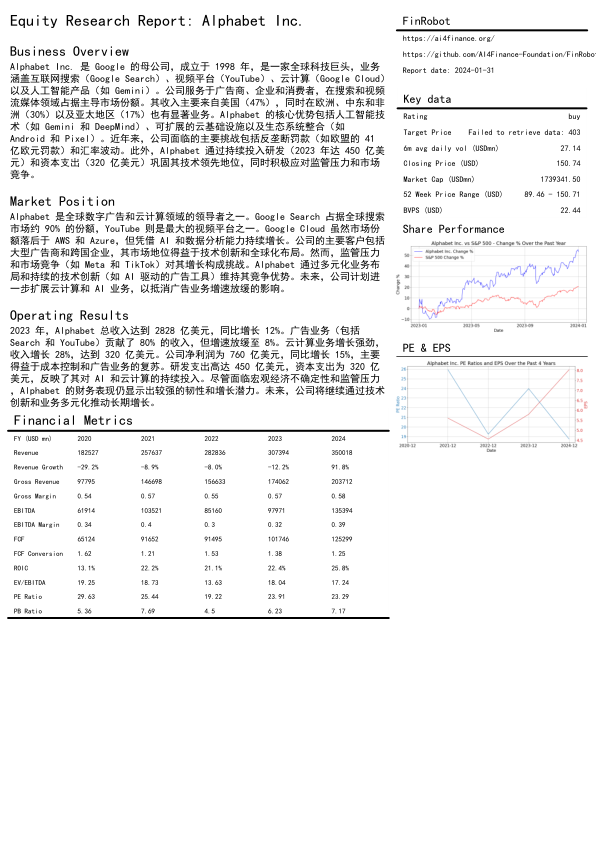

In [31]:
import io
import fitz
from PIL import Image


pdf = fitz.open("/Users/mig217/FinRobot/finrobot/report/Google_2024_Annual_Report.pdf")
page = pdf.load_page(0)
pix = page.get_pixmap()

# Convert the Pixmap to a PIL Image
img = Image.open(io.BytesIO(pix.tobytes("png")))
display(img)

In [17]:
call_build_annual_report = {
    "market_position": "Google 在 2024 年展现了其在全球科技领域的领导地位，尤其是在广告和云计算领域表现突出。Google Services 部门凭借用户参与度的提升和广告支出的增长，实现了显著的收入和利润增长。与此同时，Google Cloud 成功扭亏为盈，标志着其在企业市场的竞争力进一步增强。此外，Other Bets 部门虽然仍在亏损，但亏损幅度收窄，显示出潜在的商业化前景。总体而言，Google 的多元化业务布局和持续创新为其在竞争激烈的市场中保持领先地位奠定了坚实基础。", 
    "business_overview": "Google 是 Alphabet Inc. 的核心子公司，专注于互联网相关服务和产品、在线广告、云计算以及人工智能（AI）。作为全球数字广告市场的领导者，Google 凭借其专有的 AI 技术和多样化的产品组合（如 Google Search、YouTube 和 Google Cloud）保持了强大的竞争优势。近年来，公司在 AI 领域持续投入，推出了 Gemini 等先进模型，并致力于提升云计算能力。同时，Google 积极应对行业趋势，例如向多设备生态系统转型和可持续发展，目标是在 2030 年实现净零排放。尽管面临监管压力和市场竞争，Google 的多元化收入来源和创新能力使其在行业中保持领先地位。", 
    "filing_date": "2024-01-31", 
    "competitors_analysis": "待补充", 
    "risk_assessment": "Google 在其 2024 年 10-K 报告中详细列出了多项关键风险因素，其中最为突出的是收入过度依赖广告、激烈的市场竞争以及日益严格的监管环境。首先，Google 的主要收入来源是在线广告，占比超过 75%。这种高度集中的收入结构使其极易受到外部环境变化的影响。例如，在经济衰退期间，广告预算往往会大幅削减，这将直接影响公司的盈利能力。此外，随着广告拦截技术的普及，广告展示的有效性也可能下降，进一步削弱收入增长潜力。其次，科技行业的快速变化和激烈竞争对 Google 构成了重大挑战。为了保持市场领先地位，Google 必须持续投入大量资源进行研发和创新。然而，竞争对手（如 Meta 和 Microsoft）同样在人工智能、云计算和其他新兴领域积极布局，试图抢占市场份额。如果 Google 无法及时推出具有竞争力的新产品或服务，可能会失去现有用户基础，并导致市场份额下滑。最后，监管和法律风险是 Google 面临的另一大挑战。近年来，全球各国对科技巨头的监管力度显著加强，特别是在数据隐私、反垄断和内容审核方面。一旦违反相关规定，Google 可能面临巨额罚款甚至被迫改变商业模式。总体而言，尽管 Google 在技术和市场占有率方面具有明显优势，但上述风险因素不容忽视。如何平衡创新与合规、应对竞争压力以及降低对广告收入的依赖，将是未来几年内 Google 需要解决的关键问题。", 
    "save_path": "../FinRobot/report/google_annual_report.pdf", 
    "share_performance_image_path": "../FinRobot/report/google_share_performance.png", 
    "pe_eps_performance_image_path": "../FinRobot/report/google_pe_eps_performance.png", 
    "ticker_symbol": "GOOGL",
    "operating_results":"平安银行的运营结果描述（草稿）..."
    }



In [18]:
ReportLabUtils.build_annual_report(**call_build_annual_report)

FMP api key found successfully.
FMP api key found successfully.
FMP api key found successfully.
FMP api key found successfully.


'Annual report generated successfully.'